<h1>Environment</h1>

Verify that we have the correct version of astropy:

In [1]:
import astropy
print(astropy.__version__)

3.2.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Data input</h1>

Begin by importing the helper functions in the 'proto' package:

In [3]:
import fit_functions_specutils
from specutils import Spectrum1D, SpectralRegion

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be included in fit: simple 2-column ASCII file

In [4]:
datafile = "../../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../../data/n5548/n5548_lyalpha_sample.dat"

The read_file function reads the spectrum file and an optional regions file. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Regions is a list of SpectralRegion instances, one per region in the regions file.

Mask is a float numpy array with 1's for good data points and 0's for ignored data points. This can be used directly in the fitting engine as a weight array.

In [5]:
spectrum, regions, mask = fit_functions_specutils.read_file(datafile, regions=regionsfile)

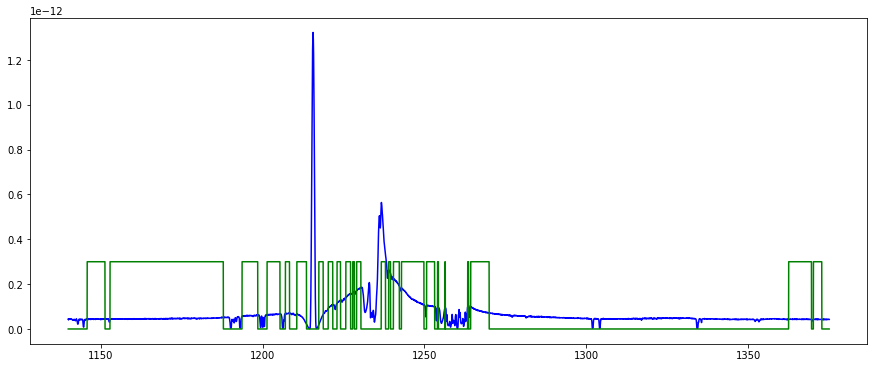

In [6]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, mask*3.E-13, 'g')

<h1>First guess model</h1>

The model is imported directly:

In [7]:
import n5548_models as models

The .py module defined above builds one or more instances of a special type of function defined in the astropy.modeling.models package, called a "compound model". 

A compound model is just a combination of astropy.modeling.models functions, using as combination operators such things as addition, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

An actual, importable model definition will look like this:

```python
from custom_models import gaussian, powerlaw, ccmext

model1 = \
    powerlaw(name = 'powerlaw1',
             amp =   6.586200E-14,
             x_0 =   1000.0,
             alpha = 0.4819233,
             bounds = {'amp':   (0., 1.00E-11),
                       'x_0':   (0., 1.00E-11),
                       'alpha': (-5., 5.)},
             fixed = {'x_0': True}
             ) \
+ \
    gaussian(name = 'C III 1176',
             norm = 2.000000E-14,
             mean = 1195.006,
             fwhm = 861.4926,
             bounds = {'norm': (0., 1.00E-10),
                       'mean': (1000., 2000.),
                       'fwhm': (1000., 2000.),
                       'skew': (1., 1.)},
             fixed = {'norm': True,
                      'mean': True,
                      'fwhm': True,
                      'skew': True},
             ) \
```             


For this exercise, we pick the model named 'model1':

In [8]:
compound_model = models.model1

The module uses some special function types, defined by overriding the standard functions in asytropy.modeling.models in module custom_models. 

This overriding is necessary because the spectral components in specfit do not conform with the standards defined in astropy.modeling.models. For example, a Gaussian in specfit is defined by an amplitude, a central wavelength, a FWHM in km/s, and a skweness parameter. In astropy.modeling.models a Gaussian is defined by an amplitude, a central wavelength, and a width in units consistent with the units of the central wavelength. And no skewness parameter. These incompatibilities are addressed by the sub-classes defined in the fit_functions module. 

In [9]:
print(compound_model)

Model: CompoundModel20
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20] + [21]
Components: 
    [0]: <powerlaw(amplitude=0., x_0=1000., alpha=0.4819233, name='powerlaw1')>

    [1]: <ccmext(ebmv=0.01713, rv=3.1, name='extinction')>

    [2]: <gaussian(norm=0., mean=1195.006, fwhm=861.4926, skew=1., name='C III 1176')>

    [3]: <gaussian(norm=0., mean=1226.392, fwhm=861.4926, skew=1., name='Si III 1206')>

    [4]: <gaussian(norm=0., mean=1236.729, fwhm=255.4998, skew=1., name='Ly alpha - NLR, ILR,  medium,  very broad')>

    [5]: <gaussian(norm=0., mean=1235.996, fwhm=861.4926, skew=1., name='gaussian5')>

    [6]: <gaussian(norm=0., mean=1235.138, fwhm=3040.59, skew=1., name='gaussian6')>

    [7]: <gaussian(norm=0., mean=1231.589, fwhm=8133.099, skew=1., name='gaussian7')>

    [8]: <gaussian(norm=0., mean=1237.643, fwhm=18183.71, skew=1

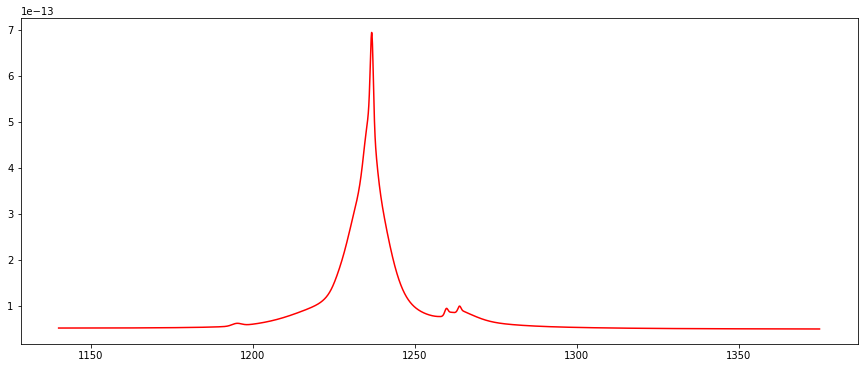

In [10]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

The actual fitting then is a very simple operation. First, we instantiate a fitter engine:

In [11]:
import astropy.modeling.fitting as fitting

In [12]:
fitter = fitting.LevMarLSQFitter()

And the fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed. Let's do some timing as well:

In [13]:
import time
start_time = time.time()

fit_result = fitter(compound_model, spectrum.spectral_axis.data, spectrum.flux.data, acc=1.E-30, maxiter=6000)

end_time = time.time()

print(end_time - start_time)

5.710120916366577


In [24]:
print(fitter.fit_info['message'])

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


The result is another instance of a compound model, with the fitted values set into the  parameter values:

In [25]:
print(fit_result)

Model: CompoundModel20
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20] + [21]
Components: 
    [0]: <powerlaw(amplitude=0., x_0=1000., alpha=0.4819233, name='powerlaw1')>

    [1]: <ccmext(ebmv=0.01713, rv=3.1, name='extinction')>

    [2]: <gaussian(norm=0., mean=1195.006, fwhm=861.4926, skew=1., name='C III 1176')>

    [3]: <gaussian(norm=0., mean=1226.392, fwhm=861.4926, skew=1., name='Si III 1206')>

    [4]: <gaussian(norm=0., mean=1236.729, fwhm=255.4998, skew=1., name='Ly alpha - NLR, ILR,  medium,  very broad')>

    [5]: <gaussian(norm=0., mean=1235.996, fwhm=861.4926, skew=1., name='gaussian5')>

    [6]: <gaussian(norm=0., mean=1235.138, fwhm=3040.59, skew=1., name='gaussian6')>

    [7]: <gaussian(norm=0., mean=1231.589, fwhm=8133.099, skew=1., name='gaussian7')>

    [8]: <gaussian(norm=0., mean=1237.643, fwhm=18183.71, skew=1

<h1>Plots</h1>

<h3>Input and output compound models</h3>

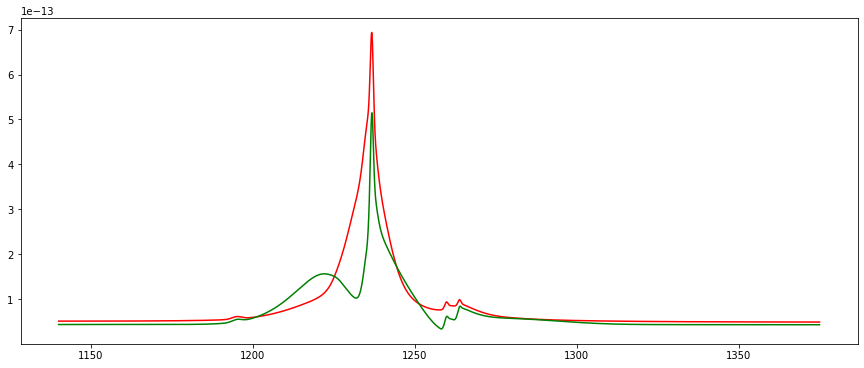

In [28]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
fitted_spectrum = fit_result(spectrum.spectral_axis.data)
plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'g')

<h3>Input compound model overploted on spectrum</h3>

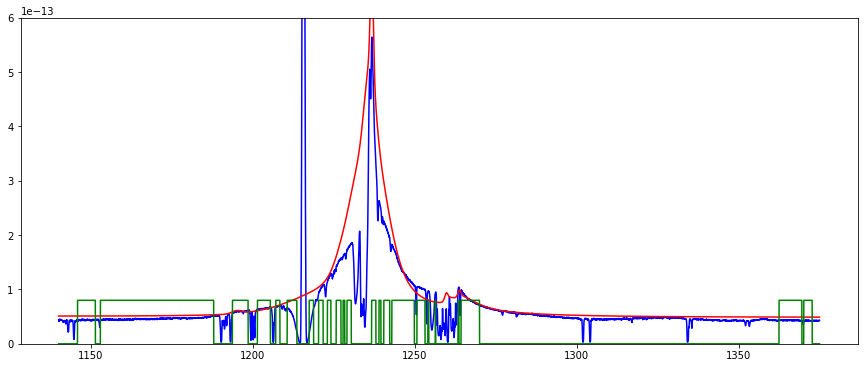

In [30]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
plt.plot(spectrum.spectral_axis.data, mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

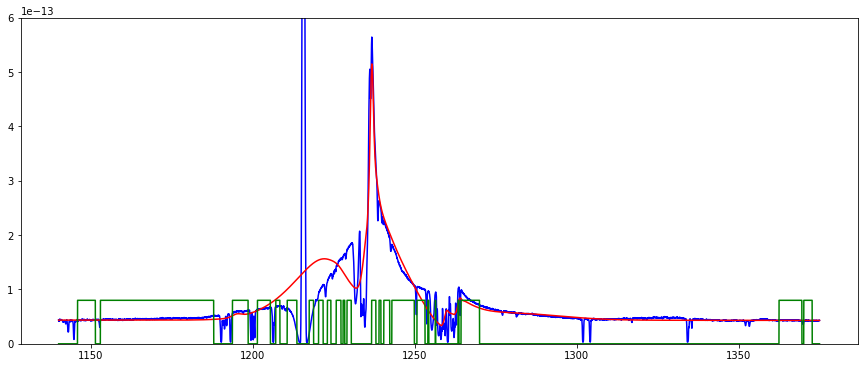

In [31]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'r')
plt.plot(spectrum.spectral_axis.data, mask*8.E-14, 'g')

<h3>Residuals</h3>

input spectrum - input model: plotted in yellow

input spectrum - fitted model: plotted in blue

In [32]:
residuals = spectrum.flux.data - fitted_spectrum
original_residuals = spectrum.flux.data - compound_model(spectrum.spectral_axis.data)

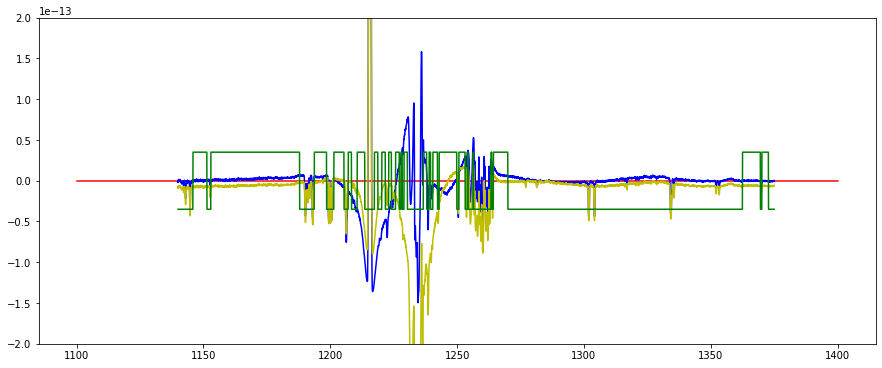

In [33]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(-2.e-13, 2.e-13)
plt.plot([1100., 1400], [0., 0.], 'r')
plt.plot(spectrum.spectral_axis.data, residuals, 'b')
plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
plt.plot(spectrum.spectral_axis.data, (mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

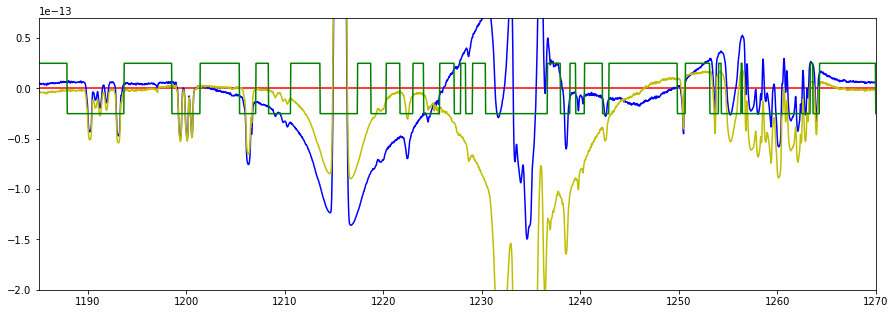

In [34]:
plt.gcf().set_size_inches(15.,5.)
plt.xlim(1185., 1270.)
plt.ylim(-2.e-13, 0.7e-13)
plt.plot([1185., 1270], [0., 0.], 'r')
plt.plot(spectrum.spectral_axis.data, residuals, 'b')
plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
plt.plot(spectrum.spectral_axis.data, (mask-0.5)*5.E-14, 'g')